# MNIST Conditional DCGAN

This exercise uses conditional DCGAN architecture to generate specific MNIST digit image. This is a continuation from previous exercise using DCGAN without condition. Previously,G and D only want to learn about the distribution of MNIST i.e. P(x) but now we want to specify the label y. In other words, we condition the distribution on the label, P(x|y). In other words, when given a specific label, we want G to generate that particular digit, and want D to recognise this digit rather than any other digit. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

print("Pytorch version:",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Pytorch version: 0.4.0


# Data

The MNIST data is PIL image range from 0 to 1. We'll transform them to range [-1, 1]. The image size is 28x28 grayscale, therefore each minibatch will have shape (128, 1, 28, 28)

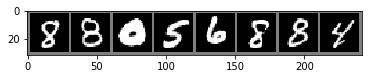

    8     8     0     5     6     8     8     4


In [2]:
batch_size = 128
labels_dim = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show some images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(8)))

# One Hot Encoding
Instead of just using single variable for label as input to the networks, we encode it using one hot encoding. Therefore, for every label say label=2, this will be converted into array of size 10 i.e. [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ]

In [3]:
def one_hot_encode(y, label=1.0):
    one_hot = torch.Tensor(len(y),labels_dim,device=device).fill_(0.0).to(device)
    one_hot.scatter_(1, y.view(-1,1), label)
    return one_hot.view(len(y), labels_dim, 1, 1)

#print(labels.shape)
#print(one_hot_encode(labels).shape)

# Generator Network

As mentioned earlier, we now take labels with shape (batch_size, 10, 1, 1) as additional input. Therefore, we create an additional transpose convolutional to transform it into size that matches the output shape from first transpose conv layer i.e (batch_size, ngf*8, 7, 7). We then concatenate the two tensors together. 


In [4]:
nz = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        # input shape : (n, nz, 1, 1)
        self.conv_t_1 =nn.ConvTranspose2d(nz, ngf*8, 7, 1, 0, bias=True)
        self.bn_1 = nn.BatchNorm2d(ngf*8)
        
        # this layer take labels as input
        self.conv_t_1l =nn.ConvTranspose2d(labels_dim, ngf*8, 7, 1, 0, bias=True)
        self.bn_1l = nn.BatchNorm2d(ngf*8)        
        
        # concatenate
        
        
        # input shape : (n, ngf*8, 7, 7)
        self.conv_t_2 =nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1, bias=True)
        self.bn_2 = nn.BatchNorm2d(ngf*4)        
        # input shape : (n, ngf*4, 14, 14)
        self.conv_t_3 =nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=True)
        # output shape : (n, 1, 28, 28)
        
    def forward(self, z, label):
        z_out = F.relu(self.bn_1(self.conv_t_1(z)))
        label_out = F.relu(self.bn_1l(self.conv_t_1l(label)))
        x = torch.cat([z_out, label_out], 1)
        x = F.relu(self.bn_2(self.conv_t_2(x)))
        
        # use tanh to squeeze the output to within [-1, +1]
        x = F.tanh(self.conv_t_3(x))
        
        return x
    
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (conv_t_1): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1))
  (bn_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_1l): ConvTranspose2d(10, 512, kernel_size=(7, 7), stride=(1, 1))
  (bn_1l): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_2): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_3): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

# Discriminator

Similar to Generator, we create an additional transpose conv layer to upscale the label vectors to (batch_size, ndf, 14, 14) that matches the output of first conv layer.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        
        # input shape : (n, nc, 28, 28)
        self.conv2d_1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=True)
        
        # label input (n, 10, 1, 1)
        # use transpose conv to upscale it to (n, ndf, 14, 14)
        self.conv2d_1l = nn.ConvTranspose2d(labels_dim, ndf, 14, 1, 0, bias=True)
        
        # concatenate to ndf*4
        # tensor shape : (n, ndf, 14, 14)
        self.conv2d_2 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=True)
        self.bn_2 = nn.BatchNorm2d(ndf*4)
        
        # tensor shape : (n, ndf*2, 7, 7)
        self.conv2d_3 = nn.Conv2d(ndf*4, 1, 7, 1, 0, bias=True)

    def forward(self, img, label):
        img = F.leaky_relu(self.conv2d_1(img), 0.2)
        y = F.leaky_relu(self.conv2d_1l(label), 0.2)
        x = torch.cat([y, img], 1)
        
        x = F.leaky_relu(self.bn_2(self.conv2d_2(x)), 0.2)
        x = F.sigmoid(self.conv2d_3(x))
        return x.view(-1,1).squeeze(1)
    
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (conv2d_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2d_1l): ConvTranspose2d(10, 64, kernel_size=(14, 14), stride=(1, 1))
  (conv2d_2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_3): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1))
)

# Objective Function and Training

Here we use the objective (loss) function from vanilla GAN that aims to minimise Jensen-Shanon divergence. In other words, to minimise the probability distribution between the real image and fake generated image. We'll first fix the G and update D; then fix D and update G.

For discriminator loss, say p is output of D() regardless of output:
- When input is real, we want to maximise log(p) or minimise -log(p)
- When input is fake, we want to minimise log(p) or minimise -log(1-p)
- Now say y is the label (0=fake, 1=real(, we can therefore combine the losses to -(y log p +(1-y) log(1-p)) which is the binary cross entropy loss

We can either do backprop after each input (real and fake), or do backprop on the sum of losses

For generator loss, input to D is always fake, and if we want to fool G by maximizing log(p) which is the same as D loss function with real input.

## Optimizer

We use Adam optimizer which incorporate momentum for faster gradient descent and seperate learning rate based for individual weight

In [6]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

display_size = 10
fixed_noise = torch.randn(display_size, nz, 1, 1, device=device)
fixed_labels = one_hot_encode(torch.tensor(range(labels_dim),dtype=torch.long, device=device),1)

print(torch.tensor(range(labels_dim,),dtype=torch.long).shape)
print(fixed_labels.shape)

torch.Size([10])
torch.Size([10, 10, 1, 1])


[0] Loss_D: 1.9330  Loss_G: 3.1661


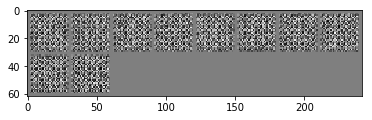

[1] Loss_D: 0.8524  Loss_G: 1.5708


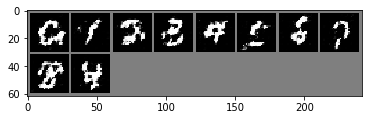

[2] Loss_D: 0.8133  Loss_G: 1.7702


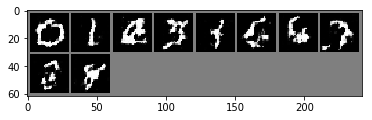

[3] Loss_D: 0.9718  Loss_G: 1.8104


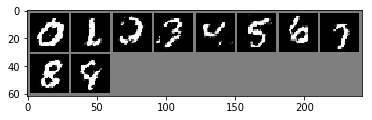

[4] Loss_D: 0.7600  Loss_G: 2.0879


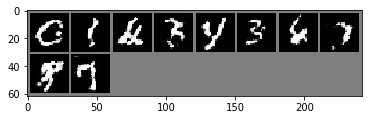

[5] Loss_D: 0.7964  Loss_G: 2.2961


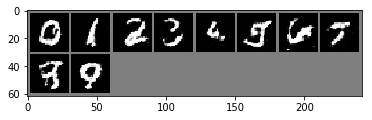

[6] Loss_D: 0.7322  Loss_G: 2.1815


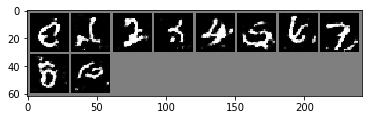

[7] Loss_D: 0.9353  Loss_G: 1.7090


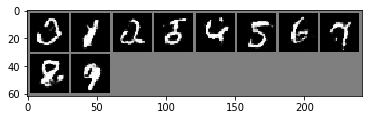

[8] Loss_D: 0.9044  Loss_G: 1.5429


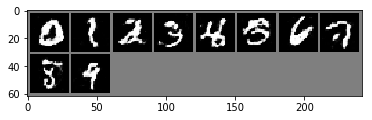

[9] Loss_D: 0.6905  Loss_G: 1.8833


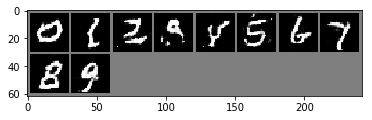

[10] Loss_D: 0.9182  Loss_G: 2.2210


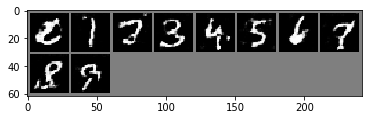

[11] Loss_D: 0.7200  Loss_G: 2.4567


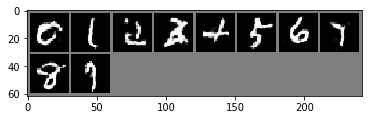

[12] Loss_D: 0.9172  Loss_G: 1.8002


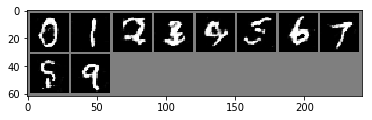

[13] Loss_D: 0.8280  Loss_G: 1.9452


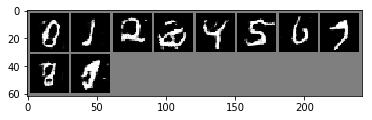

[14] Loss_D: 1.0583  Loss_G: 1.2017


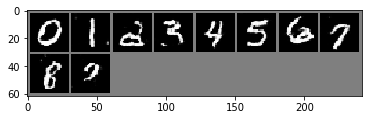

[15] Loss_D: 0.8193  Loss_G: 3.0160


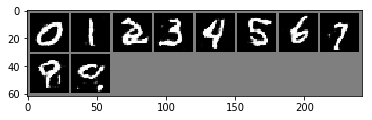

[16] Loss_D: 0.7340  Loss_G: 1.9322


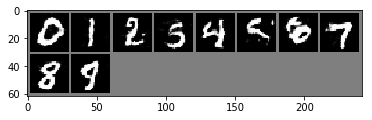

[17] Loss_D: 0.6601  Loss_G: 2.7220


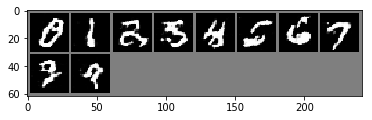

[18] Loss_D: 0.6981  Loss_G: 2.1466


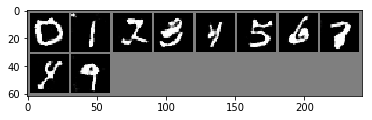

[19] Loss_D: 0.7266  Loss_G: 2.0692


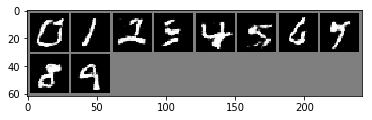

[20] Loss_D: 0.7015  Loss_G: 2.1109


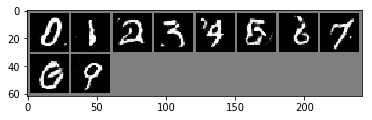

[21] Loss_D: 0.7027  Loss_G: 2.6174


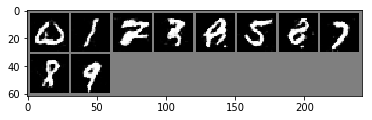

[22] Loss_D: 0.7066  Loss_G: 2.5971


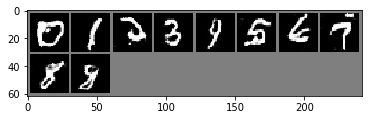

[23] Loss_D: 0.6895  Loss_G: 2.2285


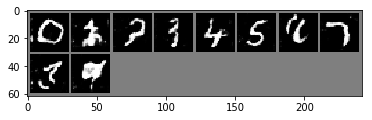

[24] Loss_D: 0.6717  Loss_G: 2.9948


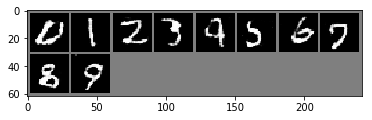

[25] Loss_D: 0.6993  Loss_G: 3.0611


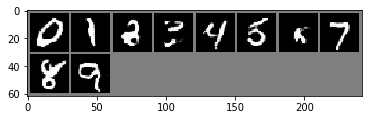

[26] Loss_D: 0.6947  Loss_G: 3.2002


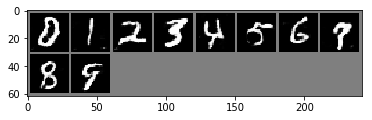

[27] Loss_D: 0.6833  Loss_G: 2.8011


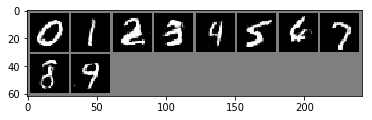

[28] Loss_D: 0.6975  Loss_G: 3.2372


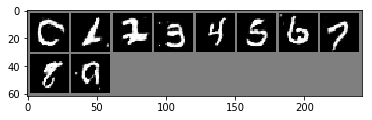

[29] Loss_D: 0.6595  Loss_G: 2.6259


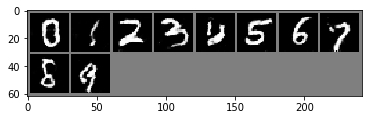

[30] Loss_D: 0.6679  Loss_G: 2.5316


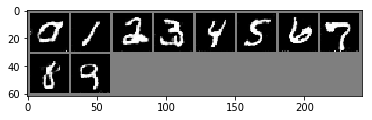

[31] Loss_D: 0.7777  Loss_G: 2.3983


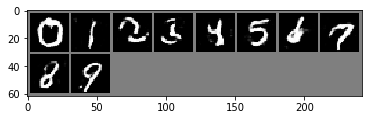

[32] Loss_D: 0.6775  Loss_G: 2.2631


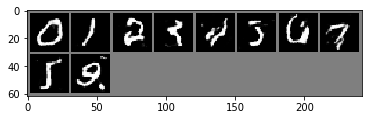

[33] Loss_D: 0.7333  Loss_G: 2.2721


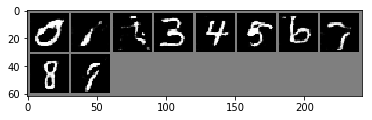

[34] Loss_D: 0.6410  Loss_G: 2.8170


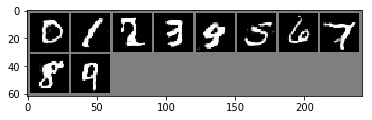

[35] Loss_D: 0.6640  Loss_G: 2.6526


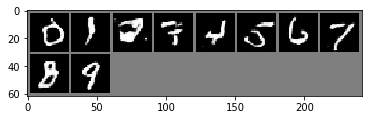

[36] Loss_D: 0.7076  Loss_G: 2.2917


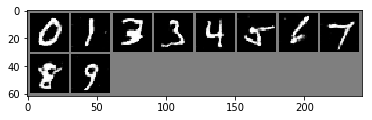

[37] Loss_D: 0.6317  Loss_G: 2.4572


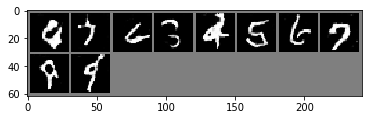

[38] Loss_D: 0.6027  Loss_G: 3.4574


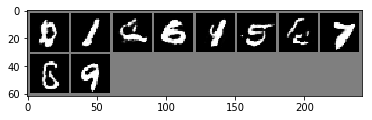

[39] Loss_D: 0.6733  Loss_G: 2.5778


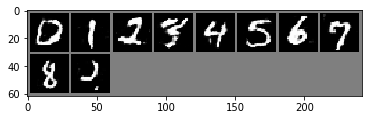

[40] Loss_D: 0.7035  Loss_G: 2.6190


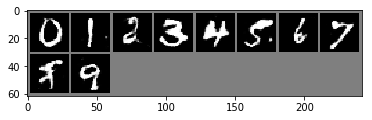

[41] Loss_D: 0.7285  Loss_G: 2.3678


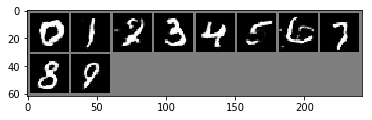

[42] Loss_D: 0.6763  Loss_G: 2.9237


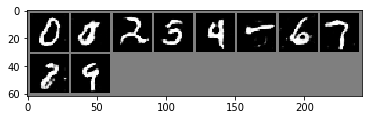

[43] Loss_D: 0.5958  Loss_G: 3.0508


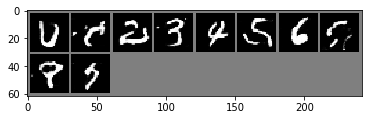

[44] Loss_D: 0.6481  Loss_G: 2.9187


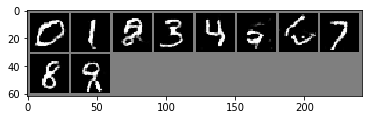

[45] Loss_D: 0.6556  Loss_G: 2.7216


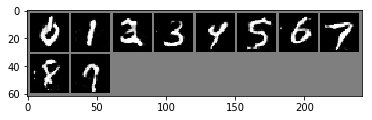

[46] Loss_D: 0.6293  Loss_G: 2.6679


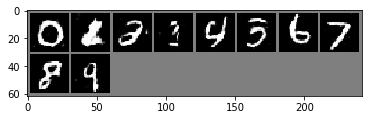

[47] Loss_D: 0.7223  Loss_G: 2.8489


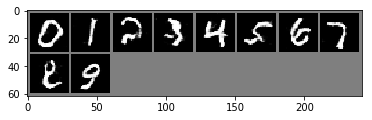

[48] Loss_D: 0.6727  Loss_G: 2.6741


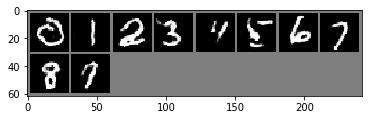

[49] Loss_D: 0.6424  Loss_G: 3.2075


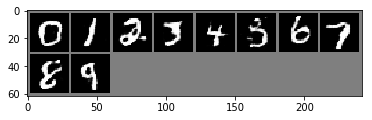

In [7]:
n_epoch = 50
n_show = 10000
n_save = 50

for epoch in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # data[0] is images, data[1] is labels
        # Discriminator - real
        netD.zero_grad()
        
        real_data = data[0].to(device)
        labels = data[1].to(device)
        batch_size = real_data.size(0)
        
        # This is a trick to use random number instead of 1.0 or 1.0. This is because at the begining, G won't
        # be generating realistic image and D might be able to discriminate it everytime and
        # leaving it with 0 zero to backprop.However, this didn't work well for this project.
        # https://github.com/soumith/ganhacks       
        real_labels = torch.full((batch_size,), 0.8, device=device)
        g_real_labels = torch.full((batch_size,), 0.8, device=device)
        fake_labels = torch.full((batch_size,), 0.0, device=device)                
        
        
        one_hot_input_labels = one_hot_encode(labels, 1)
        output = netD(real_data, one_hot_input_labels)
        loss_d_real = criterion(output, real_labels)
        loss_d_real.backward()
        
        # Discriminator - fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # generate random label
        rand_labels = torch.randint(0, labels_dim, (batch_size,), dtype=torch.long, device=device)
        one_hot_rand_labels = one_hot_encode(rand_labels, 1)

        fake_data = netG(noise, one_hot_rand_labels)
        
        # detach G's output i.e. fake_data from D so G does not get backprop
        output = netD(fake_data.detach(), one_hot_rand_labels)
        loss_d_fake = criterion(output, fake_labels)
        loss_d_fake.backward()        
        
        # Discriminator - update 2 backprop
        optimizerD.step()
        
        loss_d_total = loss_d_real + loss_d_fake
        #loss_d_total.backward()
        # Generator
        
        netG.zero_grad()
        output = netD(fake_data, one_hot_rand_labels)
        loss_g = criterion(output, g_real_labels)
        loss_g.backward()
        
        optimizerG.step()
        
        
        # show image
        if i%n_show == 0:
            print('[%d] Loss_D: %.4f  Loss_G: %.4f'%(epoch, loss_d_total.item(), loss_g.item()))
            test_imgs = netG(fixed_noise, fixed_labels)
            imshow(torchvision.utils.make_grid(test_imgs[0:10].detach().cpu()))
            
        if i%n_save == 0:
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('./models', epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('./models', epoch))